## # Sliding Window
# Feb 2019
#
import matplotlib.patches as patches
import seaborn as sns
import copy
import torchvision
from IPython.display import display  # to display images
from PIL import Image, ImageDraw
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt

import time
import os

from IPython.display import Audio

In [ ]:
# # Sliding Window
# Feb 2019
# Implement classfication and regression as two separate networks

import matplotlib.patches as patches
import seaborn as sns
import copy
import torchvision
from IPython.display import display  # to display images
from PIL import Image, ImageDraw
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt

import time
import os

from IPython.display import Audio

In [ ]:
# Make dataset -------------------------------------------------------
IMG_X, IMG_Y = 200, 200
# length and width of blocks (fixed for now)
block_l, block_w = 20, 30


def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l / 2.0, w / 2.0), (l / 2.0, -w / 2.0),
                  (-l / 2.0, -w / 2.0), (-l / 2.0, w / 2.0), ]
    return [(c * x - s * y + offset[0],
             s * x + c * y + offset[1]) for (x, y) in rectCoords]


# ---- Make depth images ---
def make_dataset(dirname, num_images):
    true_coords = []
    newpath = "./" + dirname
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        print(newpath)
    for i in range(num_images):
        # orient = 0 # degrees
        img = Image.new("RGB", (IMG_X, IMG_Y), "black")

        # block_l and _w offset so blocks don't run off edge of image
        rand_x = int(np.random.rand() * (IMG_X - 2 * block_l)) + block_l
        rand_y = int(np.random.rand() * (IMG_Y - 2 * block_w)) + block_w
        orient = int(np.random.rand() * 180)  # .random() is range [0.0, 1.0).
        orient = math.radians(orient)  # math.cos takes radians!

        true_coords.append(np.array((rand_x, rand_y, orient)))

        rect_vertices = makeRectangle(
            block_l, block_w, orient, offset=(rand_x, rand_y))

        idraw = ImageDraw.Draw(img)
        idraw.polygon(rect_vertices, fill="white")

        img.save(newpath + "/rect" + str(i) + ".png")
    return true_coords


# NOTE Define size of dataset
train_truth = make_dataset("data", 1000)
# print(len(train_truth))
test_truth = make_dataset("./data/test", 300)

np.save("train_truth.npy", train_truth)
np.save("test_truth.npy", test_truth)


train_truth = np.load("train_truth.npy")
test_truth = np.load("test_truth.npy")  # loading the training and testing data

In [ ]:

# Define Dataloader -------------------------------------------------------
class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        """
        """
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        MARGIN_PX = 15
        self.step = STEPSIZE
        self.cropSize = WINDOWSIZE
        self.detectMargin = MARGIN_PX

    def __len__(self):
        # print('true coord len', len(self.true_coords))
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + "/rect" +
                          str(idx) + ".png", as_gray=True)
        # image = torch.FloatTensor(image).permute(2, 0, 1)  # PIL and torch expect difft orders
        coords = torch.FloatTensor(self.true_coords[idx])

        if self.transform:
            image = self.transform(image)

        crops, labels, cropCoords = self.makeCrops(
            image, self.step, self.cropSize, coords, self.detectMargin)

        sample = image, torch.FloatTensor(
            labels), torch.FloatTensor(cropCoords)
        return sample

    def makeCrops(self, image, stepSize, windowSize, rectCenter, detectMargin):
        """
        Returns image crops, as well as T/F for those crops
        """
        crops = []
        c_x, c_y, theta = rectCenter
        margin = detectMargin
        hasRects = []
        rectCoords = []
        for y in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
            for x in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
                end_x, end_y = x + windowSize[1], y + windowSize[0]
                hasRect = (x + margin < c_x < end_x - margin) and (
                    y + margin < c_y < end_y - margin)
                crops.append(image[y:end_y, x:end_x])
                hasRects.append(hasRect)
                if hasRect:
                    rectCoords.append((c_x, c_y, theta))
                else:
                    # NOTE: Return empty label, when not hasRect
                    rectCoords.append((0, 0, 0))
        # print('length of truths in makeCrops', len(truths))
        return crops, hasRects, rectCoords

In [ ]:

class regrNet(nn.Module):
    def __init__(self, cropSize, numOutputs):
        """
        We need the image width and height to determine CNN layer sizes
        """
        super(regrNet, self).__init__()
        _pool = 2
        _stride = 5
        _outputlayers = 16

        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        self.step = STEPSIZE
        self.cropSize = cropSize
        self.numOutputs = numOutputs

        self.numCrops = 0
        # calculate number of crops
        for x in range(0, IMG_Y - WINDOWSIZE[0] + 1, STEPSIZE):
            for y in range(0, IMG_X - WINDOWSIZE[1] + 1, STEPSIZE):
                self.numCrops += 1

        def _calc(val):  # use to calculate layer sizes
            layer_size = (val - (_stride - 1)) / _pool
            return layer_size

        self._const = _calc(_calc(self.cropSize[0]))
        self._const *= _calc(_calc(self.cropSize[1]))
        self._const *= _outputlayers
        self._const = int(self._const)

        # --- LOCATION OF RECTANGLE
        # NOTE: only one channel for now (black/white)
        self.conv1 = nn.Conv2d(self.numCrops, 6, _stride).to(device)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, self.numOutputs * self.numCrops).to(device)

    def forward(self, crops):
        """
        Forward propogation
        : param image: images, a tensor of dimensions(N, 3, IMG_X, IMG_Y)
        : return: (x, y, theta) and T/F for each window
        """
        # TODO: presumably by doing this i lose some of the multithread goodness
        crops = crops.to(device)

        # LOCALIZATION
        regr_crops = self.pool(F.relu((self.conv1(crops))))
        regr_crops = self.pool(F.relu(self.conv2(regr_crops)))
        regr_crops = regr_crops.view(-1, self._const)
        regr_crops = F.relu(self.fc1(regr_crops))
        regr_crops = F.relu(self.fc2(regr_crops))
        regr_crops = self.fc3(regr_crops)

        objCoords = regr_crops
        # reshape to batchsize x number of crops x 3
        objCoords = objCoords.reshape(-1, self.numCrops, self.numOutputs)
        return objCoords





In [ ]:
class classifNet(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28x1)
    def __init__(self, IMG_X, IMG_Y):
        """
        We need the image width and height to determine CNN layer sizes
        """
        super(classifNet, self).__init__()
        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16

        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        self.step = STEPSIZE
        self.cropSize = WINDOWSIZE
        self.numCrops = 0
        # T/F for now

        # calculate number of crops
        for x in range(0, IMG_Y - WINDOWSIZE[0] + 1, STEPSIZE):
            for y in range(0, IMG_X - WINDOWSIZE[1] + 1, STEPSIZE):
                self.numCrops += 1

        def _calc(val):  # use to calculate layer sizes
            layer_size = (val - (_stride - 1)) / _pool
            return layer_size

        # print(self._imgx)
        # self._const = _calc(_calc(self._imgx))
        # self._const *= _calc(_calc(self._imgy))
        self._const = _calc(_calc(self.cropSize[0]))
        self._const *= _calc(_calc(self.cropSize[1]))
        self._const *= _outputlayers
        self._const = int(self._const)

        # --- CLASSIFICATION OF WINDOWS
        # batch, 3 input image channels (RGB), 6 output channels, 5x5 square convolution
        # NOTE: we switched to 1 input channel
        self.conv1 = nn.Conv2d(self.numCrops, 6, _stride).to(device)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, self.numCrops).to(device)
        self.sigmoid = nn.Sigmoid()
        # TODO: batch normalization  self.bn = nn.BatchNorm2d()
    def forward(self, x):
        """
        Forward propogation
        : param image: images, a tensor of dimensions(N, 3, IMG_X, IMG_Y)
        : return: (x, y, theta) and T/F for each window
        """
        x = x.to(device)
        batch_images = x

        all_crops = []
        for img in batch_images:
            crops = self.makeCrops(img, self.step, self.cropSize)
            all_crops.append(crops)
            # all_crops.append(crops)
        all_crops = torch.stack(all_crops)
        feats = all_crops.view(-1, self.numCrops, self.cropSize[0],
                               self.cropSize[1]).to(device)

        # CLASSIFICATION of the windows
        c_crops = self.pool(F.relu((self.conv1(feats))))
        c_crops = self.pool(F.relu(self.conv2(c_crops)))
        c_crops = c_crops.view(-1, self._const)
        c_crops = F.relu(self.fc1(c_crops))
        c_crops = F.relu(self.fc2(c_crops))
        c_crops = self.fc3(c_crops)
        c_crops = self.sigmoid(c_crops)

        containsObj = c_crops
        return containsObj, all_crops
    
    def makeCrops(self, image, stepSize, windowSize):
        """
        Returns a generator of cropped boxes(the top left x, y, the image data)
        """
        image = image.type(torch.FloatTensor).to(device)
        crops = []

        # TODO: look into ordering, why it's y,x !
        for y in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
            for x in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
                end_x, end_y = x + windowSize[1], y + windowSize[0]
                # print('This is the x and y used: ', x, '; ', y)
                crops.append(image[y:end_y, x:end_x])
        crops = torch.stack(crops)
        # self.numCrops=len(crops)
        return crops



In [ ]:
# -- Utility fxn -------------------------------------------------------
# Source: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/train.py

class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(
    epoch, epochs_since_improvement, model, optimizer, loss, best_loss, is_best
):
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {
        "epoch": epoch,
        "epochs_since_improvement": epochs_since_improvement,
        "loss": loss,
        "best_loss": best_loss,
        "model": model,
        "optimizer": optimizer,
    }
    filename = "checkpoint_v2sliding.pth.tar"
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, "BEST_" + filename)

In [14]:

def train(train_loader, c_model, r_model, classifCriterion,
          regrCriterion, optimizer1, optimizer2, epoch):
    """
    One epoch's training.
    : param train_loader: DataLoader for training data
    : param model: model
    : param criterion: for classification (crop contains an Obj, t/f)
    : param criterion: for regresion (of the x,y, theta)
    : param optimizer: optimizer
    : param epoch: epoch number
    """

    c_model.train()  # training mode enables dropout
    r_model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss
    losses2 = AverageMeter()  # loss
    start = time.time()

    for i_batch, (images, labels, coords) in enumerate(train_loader):
        data_time.update(time.time() - start)

        images = images.to(device)
        labels = labels.to(device)
        coords = coords.to(device)

        # CLASSIFICATION
        # Forward pass
        # predicted_class, predicted_locs = model(images)
        predicted_class, all_crops = c_model(images)

        # print('size of predicted vs labels',
        # predicted_class, labels)
        # print('size of predicted vs labels',
        # predicted_class.size(), labels.size())
        loss1 = classifCriterion(predicted_class, labels)
        optimizer1.zero_grad()
        loss1.backward()
        # Update model
        optimizer1.step()


        # REGRESSION 
        # Forward pass
        masked_truth = coords

        predicted_coords = r_model(all_crops)

        #labels_est = copy.deepcopy(predicted_class)
        #coords_est = copy.deepcopy(predicted_coords)
        labels_est = torch.FloatTensor(predicted_class.detach().cpu().numpy())

        mask2 = torch.round(labels_est).type_as(coords)
        mask2.unsqueeze_(2)
        # print('!---- mask2 size', mask2.size(),
        # 'coords2 size', predicted_coords.size())
        mask2 = mask2.repeat(1, 1, 3)
        # print('!---- mask2 size', mask2.size(),
        # 'coords size', predicted_coords.size())
        masked_est = mask2 * predicted_coords
        # print('!---- masked est size', masked_est.size())

        # mask = c.reshape(-1, c.size()[1], 1,
        #                 1).repeat(1, 1, zee, zed)  # add a dims
        # print('mask size', mask.size(), zee, zed)
        # goodCrops = mask * crops

        #mask_ = predicted_class.nonzero().type_as(all_crops)

        # print('!---- truth labels', labels)
        # print('!---- truth coords', coords)
        # print('!---- masked truth coords', masked_truth)

        # print('!---- predicted labels', predicted_class)
        # print('!---- predicted coords', predicted_coords)
        # print('!---- masked coords est', masked_est)
        loss2 = regrCriterion(masked_est, masked_truth)
        optimizer2.zero_grad()
        loss2.backward()

        optimizer2.step()

        #losses.update(loss1.item() + loss2.item())
        losses.update(loss1.item())
        losses2.update(loss2.item())
        batch_time.update(time.time() - start)
        start = time.time()

        # Print status
        if i_batch % print_freq == 0:
            print(
                "Epoch: [{0}][{1}/{2}]\t"
                "Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                "Loss {loss.val:.4f} ({loss.avg:.4f})\t".format(
                    epoch, i_batch, len(train_loader), batch_time=batch_time,
                    loss=losses,
                ),
                "RLoss {loss.val:.4f} ({loss.avg:.4f})\t".format(
                    epoch, i_batch, len(train_loader), batch_time=batch_time,
                    loss=losses2,
                ),
                
            )
        # free some memory since their histories may be stored
        del predicted_class, predicted_coords, images, labels, coords

In [15]:
def validate(val_loader, c_model, r_model, c_criterion, r_criterion):
    """
    One epoch's validation.
    : param val_loader: DataLoader for validation data
    : param model: model
    : param criterion: MultiBox loss
    : return: average validation loss
    """
    c_model.eval()  # eval mode disables dropout
    r_model.eval()  # eval mode disables dropout

    batch_time = AverageMeter()
    losses = AverageMeter()
    losses2 = AverageMeter()

    start = time.time()

    # Prohibit gradient computation explicity because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i_batch, (images, labels, coords) in enumerate(train_loader):
            # Move to default device
            images = images.to(device)
            labels = labels.to(device)
            coords = coords.to(device)

            # CLASSIFICATION Eval
            predicted_class, all_crops = c_model(images)
            loss1 = c_criterion(predicted_class, labels)

            # REGRESSION Eval
            predicted_coords = r_model(all_crops)

            labels_est = torch.FloatTensor(
                predicted_class.detach().cpu().numpy())

            mask2 = torch.round(labels_est).type_as(coords)
            mask2.unsqueeze_(2)
            mask2 = mask2.repeat(1, 1, 3)

            masked_est = mask2 * predicted_coords
            masked_truth = coords

            loss2 = r_criterion(masked_est, masked_truth)

            #losses.update(loss1.item() + loss2.item(), images.size(0))
            losses.update(loss1.item())
            losses2.update(loss2.item())

            batch_time.update(time.time() - start)
            start = time.time()
            
            # Print status
            if i_batch % print_freq == 0:
                print(
                    "[{0}/{1}]\t"
                    "Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                    "Loss {loss.val:.4f} ({loss.avg:.4f})\t".format(i_batch, len(val_loader), 
                                                                    batch_time=batch_time, loss=losses),
                    "Regr Loss {loss.val:.4f} ({loss.avg:.4f})\t".format(i_batch, len(val_loader), 
                                                                    batch_time=batch_time, loss=losses2)
                )

    print("\n * LOSS - {loss.avg:.3f}\n".format(loss=losses))
    print(" * REGR LOSS - {loss.avg:.3f}\n".format(loss=losses2))

    return losses.avg#, losses2.avg


In [16]:
# -- Load data -------------------------------------------------------
batch_size = 32 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)


# Dataset is depth images of rectangular blocks
train_dataset = RectDepthImgsDataset(img_dir="./data", coords=train_truth)

# Data loader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)

test_dataset = RectDepthImgsDataset(img_dir="./data/test", coords=test_truth)

# Data loader
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size, shuffle=True)

CUDA available? device:  cuda:0


In [17]:
# -- Hyperparamaters -------------------------

num_epochs = 30  # number of epochs to run without early-stopping
learning_rate = 0.001

start_epoch = 0  # start at this epoch
# number of epochs since there was an improvement in the validation metric
epochs_since_improvement = 0
best_loss = 1000.0  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader

classifModel = classifNet(IMG_X, IMG_Y)
classifModel = classifModel.to(device)

regrModel = regrNet((100, 100), 3)  # crop size in pixels; output x,y, theta
regrModel = regrModel.to(device)

# criterion = nn.BCELoss()
classifCriterion = nn.BCELoss()
regrCriterion = nn.MSELoss()
optimizer1 = torch.optim.Adam(classifModel.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(regrModel.parameters(), lr=learning_rate)

print_freq = 25  # print training or validation status every __ batches

In [18]:
def main():
    """
    Training and validation.
    """

    global epochs_since_improvement, start_epoch, best_loss, epoch, checkpoint

    print("Training model now...")

    # -- Begin training -------------------------
    for epoch in range(num_epochs):
        train(
            train_loader=train_loader,
            c_model=classifModel,
            r_model=regrModel,
            classifCriterion=classifCriterion,
            regrCriterion=regrCriterion,
            optimizer1=optimizer1,
            optimizer2=optimizer2,
            epoch=epoch,
        )

        # One epoch's validation
        val_loss = validate(val_loader=test_loader,
                            c_model=classifModel, r_model=regrModel,
                            c_criterion=classifCriterion,
                            r_criterion=regrCriterion)

        # Did validation loss improve?
        is_best = val_loss < best_loss
        best_loss = min(val_loss, best_loss)

        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" %
                  (epochs_since_improvement,))

        else:
            epochs_since_improvement = 0

        # Save checkpoint
        #save_checkpoint(epoch, epochs_since_improvement, classifModel, optimizer1,
        #                val_loss, best_loss, is_best)


# Running main!

In [19]:
main()

# alert when training is done
sound_file = '/home/rui/Downloads/newyear.ogg'
Audio(sound_file, autoplay=True)

Training model now...
Epoch: [0][0/32]	Batch Time 0.061 (0.061)	Loss 0.6898 (0.6898)	 RLoss 1245.8776 (1245.8776)	
Epoch: [0][25/32]	Batch Time 0.054 (0.055)	Loss 0.4001 (0.5141)	 RLoss 1346.1603 (1355.3952)	
[0/10]	Batch Time 0.050 (0.050)	Loss 0.3136 (0.3136)	 Regr Loss 1194.8794 (1194.8794)	
[25/10]	Batch Time 0.048 (0.048)	Loss 0.3114 (0.3343)	 Regr Loss 1262.4609 (1342.7298)	

 * LOSS - 0.334

 * REGR LOSS - 1340.757

Epoch: [1][0/32]	Batch Time 0.054 (0.054)	Loss 0.3439 (0.3439)	 RLoss 1385.3611 (1385.3611)	
Epoch: [1][25/32]	Batch Time 0.054 (0.054)	Loss 0.0483 (0.1681)	 RLoss 283.3657 (915.0728)	
[0/10]	Batch Time 0.047 (0.047)	Loss 0.0573 (0.0573)	 Regr Loss 212.1344 (212.1344)	
[25/10]	Batch Time 0.047 (0.048)	Loss 0.0314 (0.0467)	 Regr Loss 207.6944 (246.2120)	

 * LOSS - 0.046

 * REGR LOSS - 250.888

Epoch: [2][0/32]	Batch Time 0.054 (0.054)	Loss 0.0442 (0.0442)	 RLoss 196.8751 (196.8751)	
Epoch: [2][25/32]	Batch Time 0.054 (0.054)	Loss 0.0382 (0.0426)	 RLoss 153.9281 (190

[0/10]	Batch Time 0.048 (0.048)	Loss 0.0005 (0.0005)	 Regr Loss 2.2552 (2.2552)	
[25/10]	Batch Time 0.047 (0.048)	Loss 0.0002 (0.0031)	 Regr Loss 2.8563 (6.7874)	

 * LOSS - 0.003

 * REGR LOSS - 6.398

Epoch: [21][0/32]	Batch Time 0.054 (0.054)	Loss 0.0016 (0.0016)	 RLoss 1.6242 (1.6242)	
Epoch: [21][25/32]	Batch Time 0.055 (0.054)	Loss 0.0023 (0.0043)	 RLoss 2.5160 (15.2856)	
[0/10]	Batch Time 0.048 (0.048)	Loss 0.0054 (0.0054)	 Regr Loss 18.8334 (18.8334)	
[25/10]	Batch Time 0.047 (0.048)	Loss 0.0006 (0.0037)	 Regr Loss 1.6809 (10.1719)	

 * LOSS - 0.003

 * REGR LOSS - 8.675


Epochs since last improvement: 1

Epoch: [22][0/32]	Batch Time 0.054 (0.054)	Loss 0.0012 (0.0012)	 RLoss 3.2179 (3.2179)	
Epoch: [22][25/32]	Batch Time 0.056 (0.055)	Loss 0.0004 (0.0039)	 RLoss 2.3536 (10.3899)	
[0/10]	Batch Time 0.049 (0.049)	Loss 0.0003 (0.0003)	 Regr Loss 3.0567 (3.0567)	
[25/10]	Batch Time 0.048 (0.048)	Loss 0.0005 (0.0010)	 Regr Loss 2.7148 (3.5340)	

 * LOSS - 0.001

 * REGR LOSS - 3.27

In [20]:
print('All Ready!')


filename = "checkpoint_v2sliding.pth.tar"
checkpoint = torch.load(filename)
start_epoch = checkpoint['epoch'] + 1
best_loss = checkpoint['best_loss']
print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
model = checkpoint['model']


All Ready!

Loaded checkpoint from epoch 30. Best loss so far is 1.000.



/home/rui/mlenv/lib/python3.6/site-packages/torch/serialization.py:391: UserWarning: Couldn't retrieve source code for container of type classifNet. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "




FOR N =  1
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0.])
[123.0, 115.0, 0.7330383062362671]


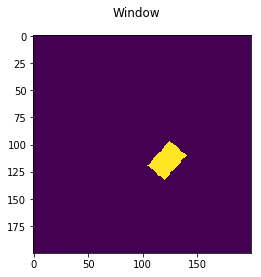

In [21]:
dataiter = iter(test_loader)
images, labels, coords = dataiter.next()

n = 1
print("\n\nFOR N = ", n)
imgSample = images[n]
max_idx = torch.argmax(coords[n][:,0])
x, y, theta = coords[n][max_idx]
print(labels[n])
print([float(zed) for zed in (x,y,theta)])
#print(x,y,theta)
#crops, __ = makeCrops(imgSample, 50, (100, 100), (x,y, theta))

plt.imshow(imgSample)
#fig, axess = plt.subplots(3,3, figsize=(10,10))
#axess = np.array(axess).flatten()#order='F') #'F' means to flatten in column-major (Fortran- style) order.
#for i in range(9):
#    axess[i].imshow(crops[i])
#    axess[i].set_ylabel('# '+str(i))
plt.suptitle('Window')
plt.show()



In [24]:
# -- Check the results -------------------------------------------------------

# -- Utility ---------------------------------------------
def makeCrops(image, stepSize, windowSize, true_center):
    """
    """
    image = image.type(torch.FloatTensor)
    crops = []
    truths = []
    c_x, c_y, orient = true_center
    # TODO: look into otdering, why it's y,x !
    margin = 15
    # --> is x, but is the column
    # to slide horizontally, y must come first
    for y in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
        for x in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
            end_x, end_y = x + windowSize[1], y + windowSize[0]
            hasRect = (x + margin < c_x < end_x - margin) and (
                y + margin < c_y < end_y - margin
            )
            truths.append(hasRect)
            crops.append(image[y:end_y, x:end_x])
    crops = torch.stack(crops)
    print("shape of crops", crops.shape)
    return crops, truths


# -- Get some validation results ---------------------------------------------
classifModel.to(device).eval()
regrModel.to(device).eval()

c_criterion = nn.BCELoss()
r_criterion = nn.MSELoss()

with torch.no_grad():
    dataiter = iter(test_loader)
    images, labels, coords = dataiter.next()
    
    # Move to default device
    images = images.to(device)
    labels = labels.to(device)
    coords = coords.to(device)

    # Forward pass
    predicted_class, all_crops = classifModel(images)
    # Loss
    loss = c_criterion(predicted_class, labels)

    
    # Forward pass
    predicted_coords = regrModel(all_crops)

    labels_est = torch.FloatTensor(
        predicted_class.detach().cpu().numpy())
    mask2 = torch.round(labels_est).type_as(coords)
    mask2.unsqueeze_(2)
    mask2 = mask2.repeat(1, 1, 3)
    masked_est = mask2 * predicted_coords
    masked_truth = coords

    # Loss
    loss2 = r_criterion(masked_est, masked_truth)

print("loss across batch size of ", labels.size()[0], 'is: ', loss, loss2)

loss across batch size of  32 is:  tensor(0.0358, device='cuda:0') tensor(65.4943, device='cuda:0')


shape of crops torch.Size([9, 100, 100])


NameError: name 'predicted_locs' is not defined

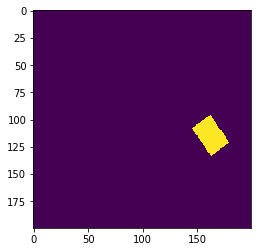

In [25]:
# -- Plot windows and print labels -----------------------------------
n = 5
imgSample = images[n]
crops, __ = makeCrops(imgSample, 50, (100, 100), (x,y, theta))
# -- Show original image, and the sliding windo crops -------
plt.imshow(imgSample)
# ---------------------------------------------------
foo_label = labels[n]

foo_coord = coords[n] 
predicted_locs = predicted_locs.view(-1,
                                     coords.size(1), coords.size(2))
foo_coord_est = predicted_locs[n] # 3 per window
foo_label_est = predicted_class[n]

max_idx = torch.argmax(foo_coord[:,0])
x, y, theta = foo_coord[max_idx]
est_max_idx = torch.argmax(foo_coord_est[:,0])
x_est, y_est, theta_est = foo_coord_est[est_max_idx]

# -- Print x,y for one result -------
# -- Print window t/f for one result -------
print("!-- FOR N = ", n)
print("y (crops) \n\t", [int(l) for l in foo_label])
print("!-- yhat (crops) \n\t", [int(np.round(p,0)) for p in foo_label_est] )
# -------------------------------------------------
sns.set(rc={"figure.figsize": (8, 6)})

print("\n\nFOR N = ", n)
print("!-- center y \n\t", [float(zed) for zed in (x, y, theta)])
print("!-- center y est \n\t ", [float(zed) for zed in (x_est, y_est, theta_est)])
print(foo_coord_est)

fig, axess = plt.subplots(3,3, figsize=(10,10))
axess = np.array(axess).flatten()#order='F') #'F' means to flatten in column-major (Fortran- style) order.
for i in range(9):
    axess[i].imshow(crops[i])
    axess[i].set_ylabel('# '+str(i))
plt.suptitle('Window')
plt.show()

#for (i, crop) in enumerate(crops):
    # print("1-index number of window: ", i+1, 'x', x, 'y', y, 'has rectangle?', hasRect)
    #plt.figure()
    #plt.suptitle("numero: %d" % (i))
    #plt.imshow(crop)

In [ ]:
#print("!-- yhat \n\t", [int(round(o, 0)) for o in outputs[n].cpu().numpy()])    
print("!-- ")
print('True locations, defined for each crop\n', foo_coord)
print("!-- ")
print('Full predicted locations (3 per crop)\n', foo_coord_est)
#print("\n ------ x,y center + orient: ", coords[n], "\n"))
print(np.argwhere(foo_coord_est > 0) )

# -- Print outputs for multiple results -------
for ix in range(5):
    print('\nSAMPLE ', ix)
    print("!-- y (crops) \n\t", [int(l) for l in labels[ix]])
    print("!-- yhat (crops) \n\t", [int(np.round(p, 0)) for p in predicted_class[ix]] )

# -- Main ---------------------------------------------
#if __name__ == '__main__':
    #main()